Goal: Take a sample from $x_1, ..., x_n$ proportional to weights $w_1, ..., w_n$ continuously. i.e. Not a multinomial smaple

Malik and Pitt resampling:

We are assuming that we have a set of uniforms that we use
to invert the cdf $\tilde{F}(x)$ above. So, we have the set of N, sorted in ascending order, uniform variates u1 < · · · < uN . The generation of the, possibly stratified, uniforms is discussed later in this appendix.


The pseudo-algorithm given below samples the index corre- sponding to the region which are stored as r1, r2, . . . , rN , and also produces a new set of uniforms, u∗1, . . . , u∗N 

set s = 0, j = 1; for {i = 0 : N}
{
    s = s + πi;
    while(uj ≤s & j≤N){
        rj =i;
        u∗j = (uj − (s − πi))/πi 
        j=j+1
}

For the selected regions where $r^j = 0$, we set $x_j^* = x^{(1)}$ and when $r^j = N$ we set $x_j^* = x^{(N)}$. Otherwise set: 
(x(rj+1) − x(rj)) × u∗j + x(rj
$x_j^* = (x^{(r^j+1)} - x^{(r^j)}) * u_j^* + x^{(r^j)}$

### Goal:

Sample $x_1,...,x_n$ from $f(x)$ with weights $\pi_j, j=1,...,n$

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd

import jax
from jax import random
import jax.numpy as jnp
from jax.experimental import checkify

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import warnings
warnings.filterwarnings("ignore")

In [2]:
@jax.jit
def continuous_cdf (xs, weights, u):
    """
    Return one sample from a continuous approximation of the ECDF of x.
    
    Should bbe trivial to extend to multiple samples if needed by: 
        list(map(lambda x: np.argmax(w_cdf > x), u))
        
    """
#     checkify.check(jnp.sum(weights) == 1, "weights must sum to 1")
    n = len(weights)
    
    pi = jnp.zeros(n + 1)
    pi = pi.at[0].set(weights[0] / 2)
    pi = pi.at[n].set(weights[-1] / 2)
    pi = pi.at[1:n].set((weights[:-1] + weights[1:]) / 2)
    
    w_cdf = jnp.cumsum(pi)
    r = np.argmax(w_cdf > u)
    u_new = (u - w_cdf[r-1]) / pi[r]
    
    # select region: 
    new_x = jax.lax.cond(
        r == 0,
        lambda _: xs[0],
        lambda _: jax.lax.cond(
            r == n,
            lambda _: xs[-1],
            lambda _: (xs[r] - xs[r-1]) * u_new + xs[r-1],
            r
        ),
        r
    )
    return new_x

# continuous_cdf = checkify.checkify(checked_cont_cdf)

In [ ]:
def sort_marginal_np (x, w):
    """ sort X and and re-arrange w to correspond to sorted indices """
    x_w = dict(zip(x, w))
    sorted_x_dict = dict(sorted(x_w.items(), key = lambda x: x[0]))
    sorted_x = jnp.array(list(sorted_x_dict.keys()))
    sorted_w = jnp.array(list(sorted_x_dict.values()))
    return sorted_x, sorted_w

In [ ]:
# generate some data: 
N = 25
rv = norm()
x = rv.rvs(size=N)

w = rv.pdf(x)
w = w / sum(w)

sorted_x, sorted_w = sort_marginal_np(x, w)

In [ ]:
%%time
sorted_x_jnp = jnp.array(sorted_x)
jnp_sorted_weights = jnp.array(sorted_w)
U = random.uniform(random.PRNGKey(0), shape = (100_000,))

# TODO: pass U as an array
jax_samples = jax.vmap(
    continuous_cdf,
    in_axes= (None, None, 0)
)(sorted_x_jnp, jnp_sorted_weights, U)
jax_samples

In [ ]:
sns.ecdfplot(x=jax_samples, alpha=0.8, color='firebrick').set(title = 'JAX continuous CDF')
sns.ecdfplot(x=x, weights = w);

# Gaussian Copula

- Find the inverse CDF for each marginal: 
    - Order each marginal and their corresponding weights: $(X^{(1)}_j, ..., X^{(n)}_j)$, $w_{1j}, ..., w_{nj}$ for $j=1,...,d$
- Estimate weighted correlation matrix, $\rho$
- Generate $Z \sim MVN(0, \rho)$
- Create uniforms using the Gaussian CDF as: $U = (\Phi(Z_1),..., \Phi(Z_d))$
- Use inverse CDF, $F^{-1}$ (`continuous_cdf`) to sample from ECDF as: $F^{-1}(X_j, w_j, U_j)$, for $j=1,...,d$

In [11]:
np.random.random(size = (N, 3))

array([[0.51395873, 0.14664837, 0.96313955],
       [0.09816557, 0.22964255, 0.4567256 ],
       [0.17216254, 0.00841702, 0.19903076],
       ...,
       [0.88537148, 0.30885362, 0.61337909],
       [0.14664497, 0.37328076, 0.27263372],
       [0.03060392, 0.36372229, 0.77957831]])

In [55]:
_cov = -1.3
mvn = stats.multivariate_normal(mean = [5, 0.4], cov = [[3, _cov], [_cov, 1]])
mvn2 = stats.multivariate_normal(mean = [1, 0.4], cov = [[2, 0], [0, 1]])
N = 1000
# X = mvn.rvs(N)
X = np.random.random(size = (N, 5))
print(X[: 5])
W = np.ones(N)/N
W = W/sum(W)

[[0.85389496 0.50038665 0.91740238 0.81815018 0.13480772]
 [0.19369463 0.71627844 0.3855114  0.17328482 0.04046915]
 [0.10729426 0.89106382 0.62919973 0.91048905 0.84044371]
 [0.50965948 0.7555156  0.1402777  0.29468819 0.02764816]
 [0.62200148 0.12057657 0.05158172 0.10003562 0.62999996]]


In [46]:
from functools import partial

@jax.jit
def jax_sort_marginal (x, w):
    """ sort X and and re-arrange w to correspond to sorted indices """
    x_w = jnp.stack((x, w)).T
    sorted_x, sorted_w = jax.lax.sort_key_val(x, w)
    return {"x": sorted_x, "w": sorted_w}


@jax.jit
def weighted_corr (X, weights):
    """
    Return weighted correlation matrix
    """
    corr_mat = jnp.cov(X, aweights = W)
    stddevs = jnp.sqrt(jnp.diag(corr_mat))
    corr_mat = corr_mat / stddevs[:, None] / stddevs[None, :]
    return corr_mat


@jax.jit
def marginal_cdf (x, data, weights):
    return sum(jnp.where(data < x, x = weights, y=0))


@partial(jax.jit, static_argnums=(3,))
def gaussian_copula (key, X, weights, N):
    """
    Estimate and sample from a Gaussian copula as follows: 
    
        - Find Y = (F_1(X_1), ..., F_d(X_d))
        - rho_hat = weighted correlation of Y 
        - Sample Z ~ N(0, rho_hat) N times
        - Create U = (phi(Z_1), ..., phi(Z_d))
        - Use inverse-CDF of marginals to create samples: (inv-CDF(U_1), ..., inv-CDF(U_d))
        
    """
    _, d = X.shape
    # estimate correlation matrix: 
    Y = jax.vmap(
        lambda x: 
        jax.vmap(
            marginal_cdf,
            in_axes = (0, None, None)
        )(x, x, W),
        in_axes = (1))(X)
    rho_hat = weighted_corr(Y, weights = W)

    # gaussian copula: 
    Z = random.multivariate_normal(key=key, mean = np.zeros(d), cov = rho_hat, shape = (N,))
    U = jax.scipy.stats.norm.cdf(Z)

    sorted_marginals = jax.vmap(
        jax_sort_marginal,
        in_axes = (1, None)
    )(X, W)

    x_samples = jax.vmap(
        lambda x, w, u: jax.vmap(
            continuous_cdf,
            in_axes= (None, None, 0)
        )(x, w, u),
        in_axes = (0, 0, 1))(sorted_marginals["x"], sorted_marginals["w"], U)

    return x_samples

In [56]:
%%time

x_samples = gaussian_copula(key = random.PRNGKey(0), X = jnp.array(X), weights = jnp.array(W), N=2000)

CPU times: user 40.5 ms, sys: 4.6 ms, total: 45.1 ms
Wall time: 38.7 ms


DeviceArray([[0.8907307 , 0.25906086, 0.5187071 , ..., 0.5933116 ,
              0.65753925, 0.48891827],
             [0.59783036, 0.04955523, 0.9200985 , ..., 0.7227751 ,
              0.6258294 , 0.6952024 ],
             [0.01372121, 0.14786962, 0.29473093, ..., 0.9943773 ,
              0.7142836 , 0.5209934 ],
             [0.6478489 , 0.21922234, 0.37721184, ..., 0.05526407,
              0.58713347, 0.92201084],
             [0.88827276, 0.34646168, 0.7975261 , ..., 0.8759732 ,
              0.5727465 , 0.7744591 ]], dtype=float32)

In [21]:
%%time
# estimate correlation matrix: 
Y = jax.vmap(
    lambda x: 
    jax.vmap(
        marginal_cdf,
        in_axes = (0, None, None)
    )(x, x, jnp.array(W)),
    in_axes = (1))(X)
rho_hat = weighted_corr(Y, weights = W)

Z = np.random.multivariate_normal(mean = np.zeros(rho_hat.shape[0]), cov = rho_hat, size = 20_000)

# gaussian copula: 
std_normal = norm()
U = std_normal.cdf(Z)

sorted_marginals = jax.vmap(
    jax_sort_marginal,
    in_axes = (1, None)
)(jnp.array(X), jnp.array(W))

x_samples = jax.vmap(
    lambda x, w, u: jax.vmap(
        continuous_cdf,
        in_axes= (None, None, 0)
    )(x, w, u),
    in_axes = (0, 0, 1))(sorted_marginals["x"], sorted_marginals["w"], U)

CPU times: user 615 ms, sys: 85.1 ms, total: 700 ms
Wall time: 412 ms


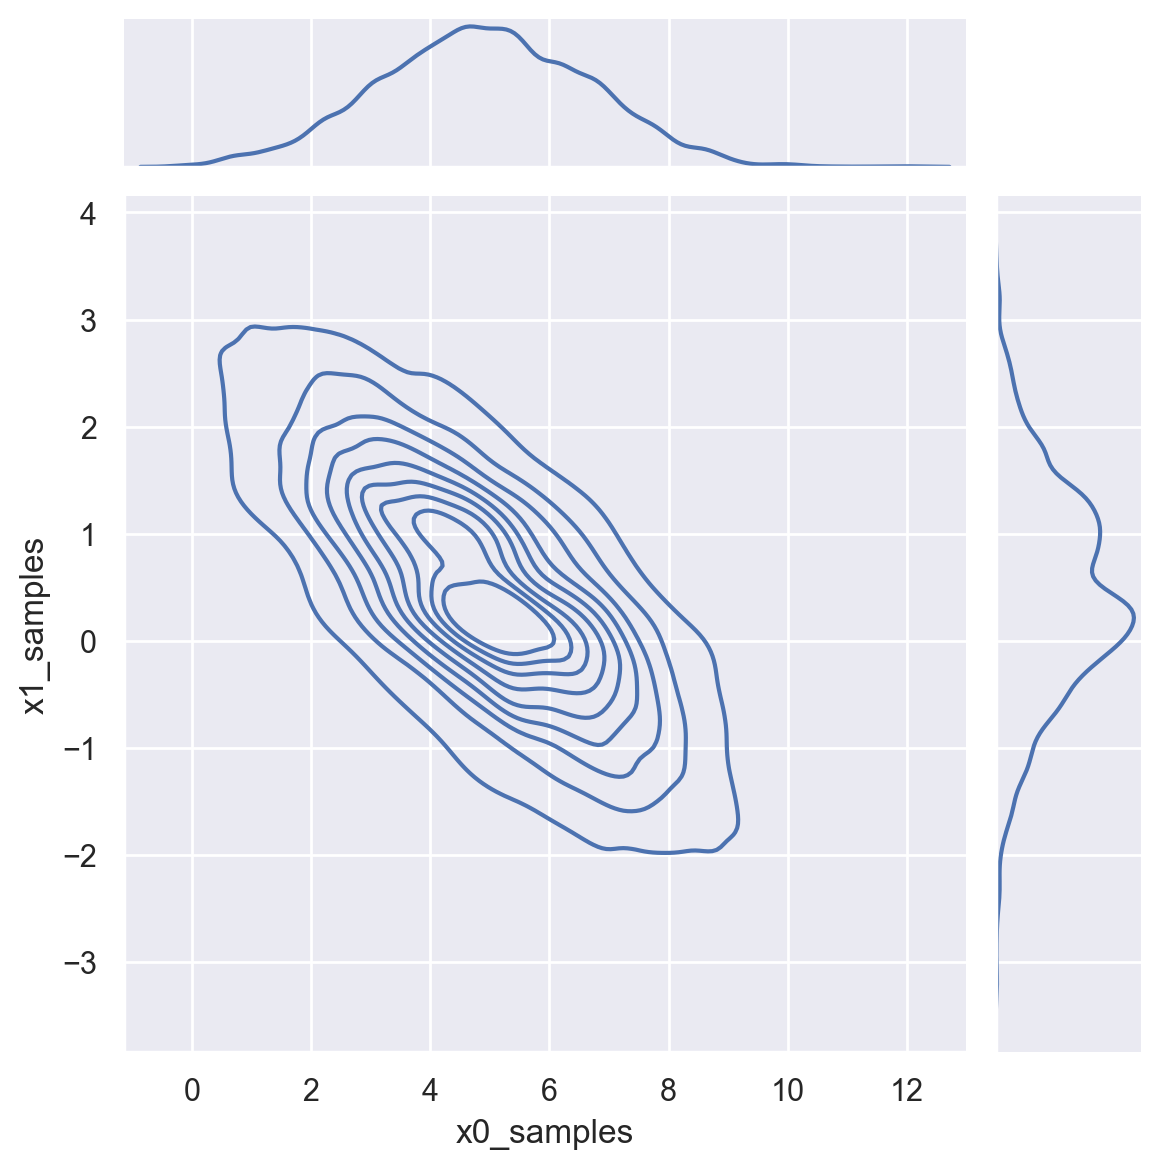

In [9]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey = True)
X_samples = pd.DataFrame(np.array(x_samples).T, columns = ["x0_samples", "x1_samples"])
sns.jointplot(x = "x0_samples", y = "x1_samples", data = X_samples, kind = "kde");

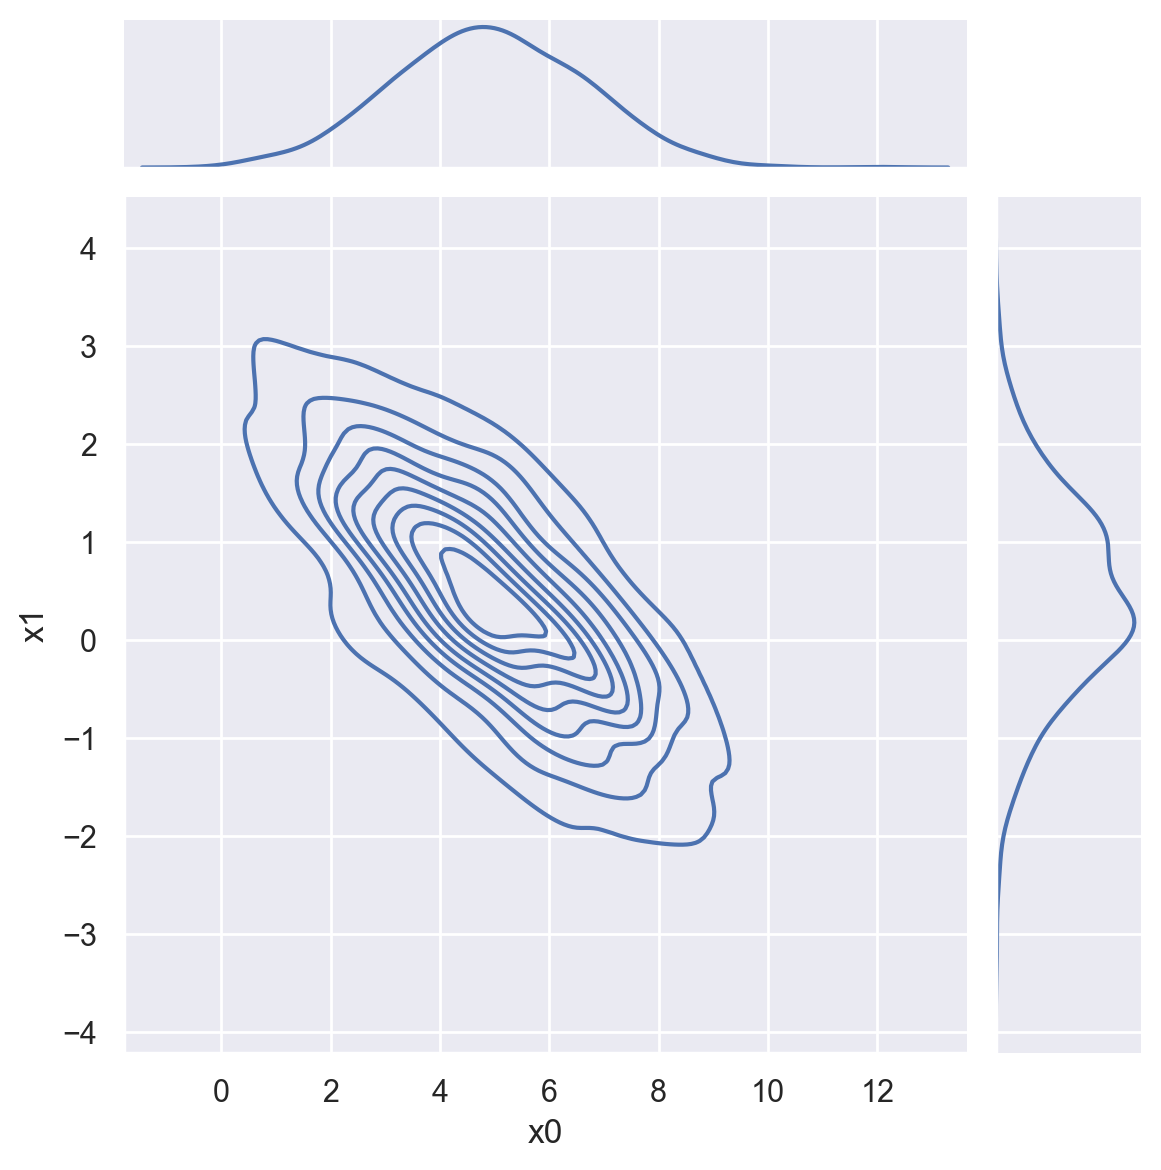

In [10]:
sns.jointplot(x = "x0", y = "x1", data = pd.DataFrame(X, columns = ["x0", "x1"]), kind = "kde");

# Deprecated

In [ ]:
def jax_cont_resample (weights, xs, key):
    """
    Change `seed` to `key`
    """
    n = len(weights)
    u_new = jnp.zeros(n)
    u0 = random.uniform(key)
    u = (u0 + np.arange(n)) / n
    u = jnp.array([0.14303787, 0.34303787, 0.54303787, 0.74303787, 0.94303787])
    
    pi = np.zeros(n + 1)
    pi[0] = weights[0] / 2
    pi[n] = weights[-1] / 2
    pi[1:n] = (weights[:-1] + weights[1:]) / 2
    
    def region_mid (k, val):
        xs = val["x"]
        r = val["r"]
        u_new = val["u_new"]
        return (xs[r[k]] - xs[r[k] - 1]) * u_new[k] + xs[r[k] - 1]
    
    def while_loop_func (val):
        u_j = val["u"][val["j"]]
        pi_i = val["pi"][val["i"]]
        
        val["r"] = val["r"].at[val["j"]].set(val["i"])
        val["u_new"] = val["u_new"].at[val["j"]].set((u_j - (val["s"] - pi_i)) / pi_i)
        
        # select region: 
        new_x = jax.lax.cond(
            val["r"][val["j"]] == 0,
            lambda _: val["x"][0],
            lambda _: jax.lax.cond(
                val["r"][val["j"]] == n,
                lambda _: val["x"][-1],
                lambda _: region_mid(val["j"], val),
                val
            ),
            val
        )
        val["x_new"] = val["x_new"].at[val["j"]].set(new_x)
        val["j"] += 1
        return val 

    def while_cond (val):
        return jnp.logical_and(val["j"] <= n, val["u"][val["j"]] <= val["s"])
    
    def for_loop_func (i, val):
        val["s"] += val["pi"][i]
        val["i"] = i
        val = jax.lax.while_loop(while_cond, while_loop_func, val)
        return val
 
    init_val = {
        "j": 0,
        "r": jnp.zeros(n, int),
        "s": 0,
        "i": 0,
        "u": u,
        "u_new": jnp.zeros(n),
        "x": xs,
        "x_new": jnp.zeros(n),
        "pi": pi}
    
    val = jax.lax.fori_loop(0, n, for_loop_func, init_val)

    # select region: 
    new_x = jax.lax.cond(
        val["r"][val["j"]] == 0,
        lambda _: val["x"][0],
        lambda _: jax.lax.cond(
            val["r"][val["j"]] == n,
            lambda _: val["x"][-1],
            lambda _: region_mid(val["j"], val),
            val
        ),
        val
    )
    val["x_new"] = val["x_new"].at[val["j"]].set(new_x)
    
    return val["x_new"]

def continuous_stratified_resample(weights, xs):
    """
    Args: 
        - weights: normalized weights with indices corresponding to xs. This is represented by \pi in the paper
        - xs: samples sorted in ascending order. Represented by x^{(k)} in the paper. 

    """
    n = len(weights)
    u0 = np.random.uniform(size=1)
    u = (u0 + np.arange(n)) / n
    u = np.array([0.14303787, 0.34303787, 0.54303787, 0.74303787, 0.94303787])
#     print(u)
    
    # A.1: general form of continuous distribution
    pi = np.zeros(n + 1)
    pi[0] = weights[0] / 2
    pi[n] = weights[-1] / 2
    pi[1:n] = (weights[:-1] + weights[1:]) / 2

    # A.3
    r = np.zeros(n)
    u_new = np.zeros(n)
    s = 0
    j = 1

    for i in range(n + 1):
        s = s + pi[i]
        while(j <= n and u[j - 1] <= s):
            r[j - 1] = i
            u_new[j - 1] = (u[j - 1] - (s - pi[i])) / pi[i]
            j = j + 1

    r = r.astype(int)

    x_new = np.zeros(n)
    for k in range(n):
        if r[k] == 0:
            x_new[k] = xs[0]
        elif r[k] == n:
            x_new[k] = xs[-1]
        else:
            x_new[k] = (xs[r[k]] - xs[r[k] - 1]) * u_new[k] + xs[r[k] - 1]
    return x_new

In [ ]:
N = 25
rv = norm()
x = rv.rvs(size=N)
print(x)

w = rv.pdf(x)
w = w / sum(w)
print(w)

x_dict = dict(zip(x, w))
print(x_dict.keys())

sorted_x_dict = dict(sorted(x_dict.items(), key = lambda x: x[0]))
sorted_x = np.array(list(sorted_x_dict.keys()))
sorted_weights = np.array(list(sorted_x_dict.values()))
sorted_x_dict

In [ ]:
print("Numpy version (fixed U): ", continuous_stratified_resample(sorted_weights, sorted_x))

print("JAX version (fixed U): ", jax_cont_resample(jnp.array(sorted_weights), 
                                                   jnp.array(sorted_x), 
                                                   key = random.PRNGKey(0)))


x_new_samples = [continuous_stratified_resample(sorted_weights, sorted_x) for i in range(200)]
x_new_samples = np.array(x_new_samples).flatten()

sns.ecdfplot(x=x_new_samples, alpha=0.8, color='firebrick').set(title = 'numpy continuous CDF')
sns.ecdfplot(x=x, weights = w);


keys = jax.random.split(random.PRNGKey(0), 200)
jax_x_new_samples = [jax_cont_resample(sorted_weights, sorted_x, key = keys[i]) for i in range(200)]
jax_x_new_samples = np.array(jax_x_new_samples).flatten()

sns.ecdfplot(x=jax_x_new_samples, alpha=0.8, color='firebrick').set(title = 'JAX continuous CDF')
sns.ecdfplot(x=x, weights = w);

In [ ]:
## TEST: check weighted correlation matrix 

rho_hat = np.cov([u0, u1], aweights = W)
_vars = np.diag(np.cov([u0, u1], aweights = W))
rho_hat[0, 1] = rho_hat[0, 1] / np.sqrt(_vars[0] * _vars[1])
rho_hat[1, 0] = rho_hat[0, 1]
rho_hat[0,0] = 1
rho_hat[1,1] = 1
print(rho_hat)

rho_hat = np.cov([u0, u1], aweights = W)
stddevs = np.sqrt(np.diag(rho_hat))
print(rho_hat / stddevs[:, None] / stddevs[None, :])


# TEST: check ECDF
x0_ecfd = lambda x: sum(W[X[:, 0] < x])
x1_ecfd = lambda x: sum(W[X[:, 1] < x])

u0 = list(map(x0_ecfd, X[:,  0]))
u1 = list(map(x1_ecfd, X[:,  1]))

In [ ]:
# %%time
# # estimate CDF for each margin: 

# # X0: 
# x0 = X[:, 0]
# w0 = norm(loc = np.mean(x0), scale = np.std(x0)).pdf(x0)
# w0 = w0 / sum(w0) # normalized weights: 

# # sort x and w:
# x0_w0 = dict(zip(x0, w0))
# sorted_x0_dict = dict(sorted(x0_w0.items(), key = lambda x: x[0]))
# sorted_x0 = jnp.array(list(sorted_x0_dict.keys()))
# sorted_w0 = jnp.array(list(sorted_x0_dict.values()))

# U = random.uniform(random.PRNGKey(0), shape = (10_000,))

# jax_samples = jax.vmap(
#     continuous_cdf,
#     in_axes= (None, None, 0)
# )(sorted_x0, sorted_w0, U)

# sns.ecdfplot(x=jax_samples, alpha=0.8, color='firebrick').set(title = 'JAX continuous CDF');
# sns.ecdfplot(x=x0, weights = w0, alpha=0.8);


# # X1: 
# x1 = X[:, 1]
# w1 = norm(loc = np.mean(x1), scale = np.std(x1)).pdf(x1)
# w1 = w1 / sum(w1) # normalized weights: 

# # sort x and w:
# x1_w1 = dict(zip(x1, w1))
# sorted_x1_dict = dict(sorted(x1_w1.items(), key = lambda x: x[0]))
# sorted_x1 = jnp.array(list(sorted_x1_dict.keys()))
# sorted_w1 = jnp.array(list(sorted_x1_dict.values()))

# U = random.uniform(random.PRNGKey(0), shape = (10_000,))

# jax_samples = jax.vmap(
#     continuous_cdf,
#     in_axes= (None, None, 0)
# )(sorted_x1, sorted_w1, U)

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey = True)
# sns.ecdfplot(x=jax_samples, alpha=0.8, color='firebrick', ax = ax).set(title = 'JAX continuous CDF');
# sns.ecdfplot(x=x1, weights = w1, alpha=0.4, ax = ax);